# Time Series Analysis

## Load Packages

In [1]:
using Dates, DelimitedFiles, LinearAlgebra, Distributions, StatsBase

include("jlFiles/printmat.jl")            
include("jlFiles/ARMAFilter.jl")
include("jlFiles/VARFilter.jl")
include("jlFiles/lagnFn.jl")

lagnFn

In [2]:
using Plots

backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

## Load Data

In [3]:
xx  = readdlm("Data/RvSP500.csv",',',skipstart=1)
y   = xx[:,3]            #SP500 log realized monthly volatility
xx  = nothing

T   = size(y,1)
println("Sample size: $T")

Sample size: 574


# Descriptive Statistics

## Autocorrelations

That is, the correlation of $y_{t}$ and $y_{t-s}$ for different values of $s$.

It can be shown that the t-stat of an autocorrelation is $\sqrt{T}$ times the autocorrelation. 

We can test the first $L$ autocorrelations by the Box-Pierce test.

In [4]:
L = 5                
lags = 1:L
ρ = autocor(y,lags)         #using the StatsBase package

println("Autocorrelations")
println("     lag   autocorrr    t-stat")
printmat([lags ρ sqrt(T)*ρ])

BP = T*sum(ρ.^2)

println("Box-Pierce test stat and 10% critical value")
printmat([BP quantile(Chisq(L),0.9)])

Autocorrelations
     lag   autocorrr    t-stat
     1.000     0.709    16.982
     2.000     0.602    14.419
     3.000     0.529    12.684
     4.000     0.459    11.000
     5.000     0.455    10.903

Box-Pierce test stat and 10% critical value
   897.040     9.236



# White Noise

To estimate: traditional sample mean and standard deviation.

In [5]:
μ = mean(y)
σ = std(y)

println("Mean and std")
printmat([μ σ])

Mean and std
     2.567     0.437



# AR(p)


## Impulse Response Function of an AR Process

The impulse responses
     0.000     1.000     1.000
     1.000     0.850     0.850
     2.000     0.722     0.222
     3.000     0.614    -0.236
     4.000     0.522    -0.312
     5.000     0.444    -0.147
     6.000     0.377     0.031
     7.000     0.321     0.100
     8.000     0.272     0.069



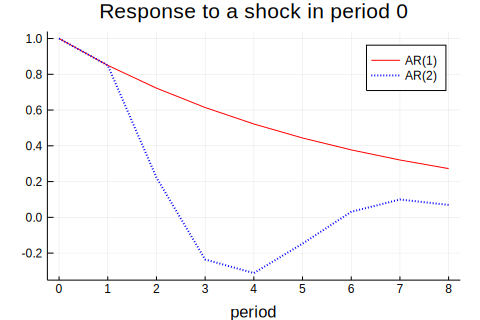

In [6]:
a = 0.85              #AR(1)

(a₁,a₂) = (0.85,-0.5)  #AR(2)

ϵ = [0;0;1;zeros(8)]  #a shock in period 3, otherwise zeros              
T = length(ϵ)
periods = 0:T-3

(y1,y2) = (zeros(T),zeros(T))           #convenient to start with zeros
for t = 3:T
    y1[t] = a*y1[t-1] + ϵ[t]
    y2[t] = a₁*y2[t-1] + a₂*y2[t-2] + ϵ[t]  #or y2 = ARMAFilter(ϵ,[a₁,a₂])
end    
y1 = y1[3:end]                           #cutting padded part
y2 = y2[3:end]

println("The impulse responses")
printmat([periods y1 y2])


plot( periods,y1,label="AR(1)",color=:red,xticks=-2:T-2)
plot!(periods,y2,label="AR(2)",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Response to a shock in period 0")

In [7]:
"""
    Companion form of AR(p), that is, write AR(p) as a VAR(1)
"""
function CompanionFormAR(a)
    p = length(a)
    if p > 1                      #if order > 1
        A1 = vcat(a',[I  zeros(p-1)])
    else                          #if already VAR(1)
        A1 = copy(a)
    end
    return A1
end

CompanionFormAR

In [8]:
λ = eigen(CompanionFormAR([a₁,a₂])).values    #eigenvalues of the companion form 

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     0.707
     0.707



## Estimation of an AR Process

The next cell defines a function estimating an AR(p) process. It calls on `lagnFn(y,s)` which is a convenience function for constructing a $Txn$ matrix with lag $s$ of y, padded with `NaN` at the top (`[fill(NaN,p,n); y[1:T-s,:]]`. 

In [9]:
function ARpEst(y,p)
    T    = length(y)
    y_p  = y[p+1:end]       #dependent variable
    xAll = fill(NaN,(T,p))  #build matrix of regressors
    for s = 1:p
        xAll[:,s] = lagnFn(y,s)
    end    
    xAll = [xAll[p+1:end,:] ones(T-p)]   #add constant last
    #printmat([y_p xAll][1:10,:])        #uncomment to see the regressors
    b  =  xAll\y_p          #OLS 
    a = b[1:end-1]        #slopes
    return a
end

ARpEst (generic function with 1 method)

In [10]:
aAR1 = ARpEst(y,1)
aAR2 = ARpEst(y,2)

println("Estimated AR(1) coef: ",aAR1)
println("Estimated AR(2) coefs: ",aAR2)

Estimated AR(1) coef: [0.71292]
Estimated AR(2) coefs: [0.569103, 0.20371]


## Forecasting with an AR Process

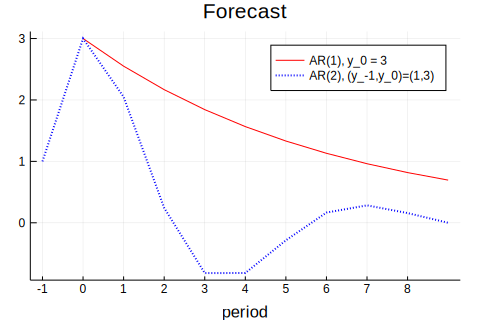

In [11]:
T = 10

y1 = [3;zeros(T-1)]
for t = 2:T                       #AR(1)
    y1[t] = a*y1[t-1]
end
periods1 = 0:T-1

y2 = [1;3;zeros(T-1)]             #y[-1] = 1, y[0] = 3, notice the order
for t = 3:T                       #AR(2)
    y2[t] = a₁*y2[t-1] + a₂*y2[t-2]
end
periods2 = -1:T-1

plot(periods1, y1,label="AR(1), y_0 = 3",color=:red,xticks=-2:T-2)
plot!(periods2,y2,label="AR(2), (y_-1,y_0)=(1,3)",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Forecast")

In [12]:
println("We can also use ARMAFilter() to do the forecasts")

y2b = ARMAFilter(zeros(T-1),[a₁,a₂],[],1,[1,3])
y2b = [[1,3];y2b]       #pad the initial values to get same as in figure

printmat([y2 y2b])               

We can also use ARMAFilter() to do the forecasts
     1.000     1.000
     3.000     3.000
     2.050     2.050
     0.242     0.242
    -0.819    -0.819
    -0.817    -0.817
    -0.285    -0.285
     0.166     0.166
     0.284     0.284
     0.158     0.158
     0.000    -0.007



## Partial Autocorrelations

The partial autocorrelation coefficient is the regression coefficients on $x_{t-p}$ in an AR(p) regression.

In [13]:
pac = pacf(y,lags)

println("autocorr pac")
println("     lag    autocorr   pac")
printmat([lags ρ pac])

autocorr pac
     lag    autocorr   pac
     1.000     0.709     0.713
     2.000     0.602     0.204
     3.000     0.529     0.103
     4.000     0.459     0.031
     5.000     0.455     0.130



# MA(q)

## Impulse Response Function of an MA Process

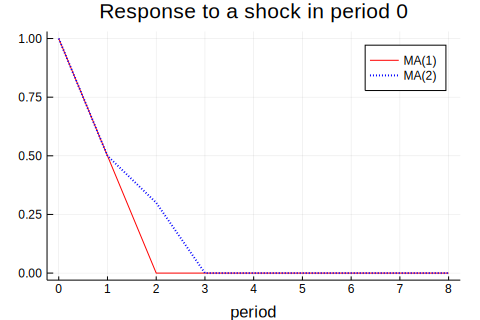

In [14]:
θ = 0.5             #MA(1)

(θ₁,θ₂) = (0.5,0.3)  #MA(2)

ϵ = [0;0;1;zeros(8)]  #a shock in period 3, otherwise zeros              
T = length(ϵ)
periods = 0:T-3

(y1,y2) = (fill(NaN,T),fill(NaN,T))       
for t = 3:T                                
    y1[t] = ϵ[t] + θ*ϵ[t-1]
    y2[t] = ϵ[t] + θ₁*ϵ[t-1] + θ₂*ϵ[t-2]   #or y2=ARMAFilter(ϵ,[],[θ₁,θ₂])
end        
y1 = y1[3:end]                           #cutting padded part
y2 = y2[3:end]


plot( periods,y1,label="MA(1)",color=:red,xticks=periods)
plot!(periods,y2,label="MA(2)",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Response to a shock in period 0")

## Estimation of an MA(q), extra

In [15]:
function MAqLL(par::Vector,y)
    (θ,σ) = (par[1:end-1],par[end])   
    q     = length(θ)
    ϵ     = ARMAFilter(y,-θ)           #ϵ is AR(q) with coefs -θ
    LL_i  = -1/2*log(2*pi) .- 1/2*log(σ^2) .- 1/2*ϵ.^2/σ^2
    LL    = -sum(LL_i)                 #minimize this
    return LL,ϵ
end

MAqLL (generic function with 1 method)

In [16]:
using Optim

println("estimate an MA(4)")
par0 = [0.5,0.3,0,0,1]   #θ₁,θ₂,θ₃,θ₄,σ     
Sol = optimize(par->MAqLL(par,y)[1],par0)    

θ = Optim.minimizer(Sol)[1:end-1]

printlnPs("The minimum is at : ",θ)

estimate an MA(4)
The minimum is at :      1.458     1.552     1.170     0.516


In [17]:
λ = eigen(CompanionFormAR(-θ)).values    #eigenvalues of the companion form 

println("absolute values of the eigenvalues: should be < 1 for MLE to be valid")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for MLE to be valid
     0.901
     0.901
     0.798
     0.798



# VAR



## Impulse Response Function of a VAR Process

In [18]:
A1 = [0.5 0.2;
      0.1 -0.3]

ϵ1 = [0 0;0 0;1 0;zeros(8,2)]              #shock to variable 1 in t=0
y1 = VARFilter(ϵ1,A1,zeros(1,2))           #IR of both variables 
ϵ2 = [0 0;0 0;0 1;zeros(8,2)]              #shock to variable 2 in t=0
y2 = VARFilter(ϵ2,A1,zeros(1,2))           #IR of both variables 
y1 = y1[3:end,:]                           #cutting padded part
y2 = y2[3:end,:]

periods = 0:T-3

println("The impulse responses")
printmat([periods y1 y2])

The impulse responses
     0.000     1.000     0.000     0.000     1.000
     1.000     0.500     0.100     0.200    -0.300
     2.000     0.270     0.020     0.040     0.110
     3.000     0.139     0.021     0.042    -0.029
     4.000     0.074     0.008     0.015     0.013
     5.000     0.038     0.005     0.010    -0.002
     6.000     0.020     0.002     0.005     0.002
     7.000     0.011     0.001     0.003    -0.000
     8.000     0.006     0.001     0.001     0.000



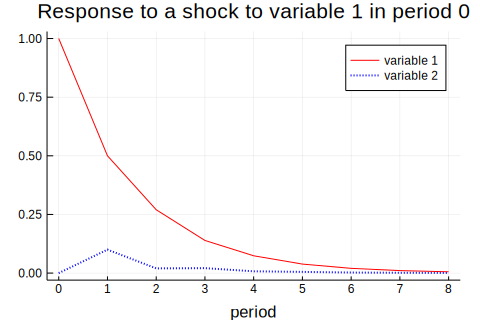

In [19]:
plot( periods,y1[:,1],label="variable 1",color=:red,xticks=-2:T-2)
plot!(periods,y1[:,2],label="variable 2",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Response to a shock to variable 1 in period 0")

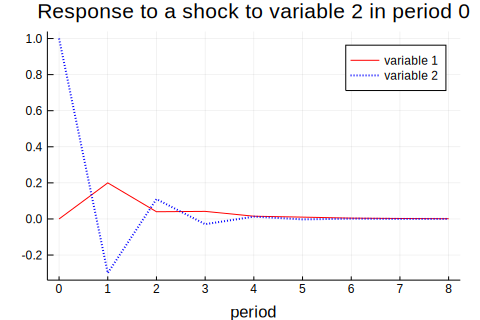

In [20]:
plot( periods,y2[:,1],label="variable 1",color=:red,xticks=-2:T-2)
plot!(periods,y2[:,2],label="variable 2",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Response to a shock to variable 2 in period 0")

## Forecasting with a VAR Process

could also use VARFilter() to do the forecasts
     0.000     1.000     2.000     1.000     2.000
     1.000     0.900    -0.500     0.900    -0.500
     2.000     0.350     0.240     0.350     0.240
     3.000     0.223    -0.037     0.223    -0.037
     4.000     0.104     0.033     0.104     0.033
     5.000     0.059     0.000     0.059     0.000
     6.000     0.029     0.006     0.029     0.006
     7.000     0.016     0.001     0.016     0.001
     8.000     0.008     0.001     0.008     0.001
     9.000     0.004     0.000     0.004     0.000



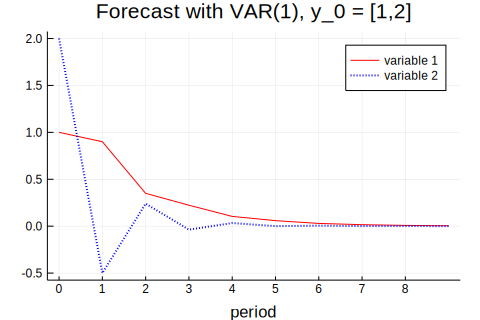

In [21]:
T = 10

y0 = [1 2]                        #initial values in t=0 

y2 = [y0;zeros(T-1,2)]
for t = 2:T
    y2[t,:] = A1*y2[t-1,:]
end    
periods = 0:T-1


println("could also use VARFilter() to do the forecasts")
y2b = VARFilter(zeros(T-1,2),A1,y0)
y2b = [y0;y2b]
printmat([periods y2 y2b])


plot(periods, y2[:,1],label="variable 1",color=:red,xticks=-2:T-2)
plot!(periods,y2[:,2],label="variable 2",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Forecast with VAR(1), y_0 = [1,2]")

# Non-Stationary Processes

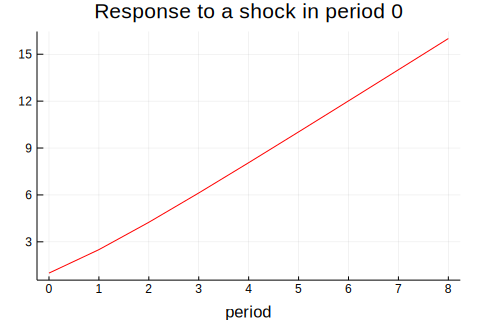

In [22]:
a = [2.5,-2,0.5]                      #AR(3) coefficients

ϵ = [0;0;1;zeros(8)]  #a shock in period 3, otherwise zeros   
T = length(ϵ)
periods = 0:T-3

y1 = ARMAFilter(ϵ,a)
y1 = y1[3:end]

plot( periods,y1,label="",color=:red,xticks=-2:T-2)
xlabel!("period")
title!("Response to a shock in period 0")

In [23]:
λ = eigen(CompanionFormAR(a)).values    #eigenvalues of the companion form 

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     1.000
     1.000
     0.500

